In [89]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.9 MB/s eta 0:00:0000:0100:01m
Note: you may need to restart the kernel to use updated packages.


### Import necessary libraries

In [90]:
import spacy 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
import re 

### Loading English language model

In [91]:
nlp = spacy.load("en_core_web_sm")

## Cleaning the text

Modifying the text in a way in such a way that it makes processing the text easier. This includes removing punctuation, converting the text to lowercase, and removing any commonly used words.

In [92]:
def preprocess(text):
    text = text.lower()

    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = nlp(text)

    text = [token.lemma_ for token in text if not token.is_stop]
    text = " ".join(text)
    return text

In [93]:
preprocess("Learning new things is so much fun! I love exploring the world and discovering new ideas.")

'learn new thing fun love explore world discover new idea'

# Character Identification Solutions

### Part of Speech (POS) Tagging

Using POS tagging, I can identify the nouns in the text. This method may not be as accurate as NER, but it can help me identify the characters in the text.

In [94]:
def proper_nouns(tagged_text):
    proper_nouns = []
    i = 0
    while i < len(tagged_text):
        if tagged_text[i][1] == 'NNP':
            if i < len(tagged_text) - 1 and tagged_text[i + 1][1] == 'NNP':
                proper_nouns.append(tagged_text[i][0].lower() + ' ' + tagged_text[i + 1][0].lower())
                i += 1
            else:
                proper_nouns.append(tagged_text[i][0].lower())
        i += 1
    return proper_nouns

def characters_in_text(file):
    with open(file, 'r') as f:
        text = f.read()
        
    doc = nlp(text)
    characters = proper_nouns([(word.text, word.tag_) for word in doc])
    return characters

In [95]:
print(characters_in_text('texts/alice.txt'))

['alice', 'wonderland', 'alice', 'wonderland', 'lewis carroll', 'millennium fulcrum', 'edition', 'rabbit', 'hole', 'alice', 'alice', 'white', 'rabbit', 'alice', 'rabbit', 'rabbit', 'watch', 'alice', 'alice', 'alice', 'orange marmalade', 'alice', 'think--', 'alice', '--yes', 'longitude', 'alice', 'latitude', 'longitude', "ma'am", 'new zealand', 'australia', 'alice', "dinah'll", 'dinah', 'dinah', 'alice', 'dinah', 'dinah', 'alice', 'white rabbit', 'alice', 'rabbit', 'alice', 'alice', 'alice', 'dark', 'alice', 'alice', 'alice', 'alice', 'alice', 'alice', 'alice', 'alice', 'alice', 'alice', 'alice', 'alice', 'chapter ii', 'pool', 'curiouser', 'alice', 'english', 'good', 'alice', 'christmas', 'alice', 'foot', 'esq', 'hearthrug', 'near the', 'fender', "alice 's", 'love', 'poor alice', 'alice', 'white rabbit', 'duchess', 'duchess', '!', 'alice', 'rabbit', 'rabbit', 'alice', 'dear', 'that', 'ada', 'mabel', 'she', 'multiplication table', 'geography', 'london', 'paris', 'paris', 'rome', 'rome', 

# Named Entity Recognition (NER)

Using NER, I can identify the entities in the text. Identifying the entity as a person could help me to identify the characters in the text. But in some instances where the character is not a person, this method may not work. 

For example, (Alice in Wonderland) Lobster Quadrille is a dance that Alice attends and is not a person. 

In [96]:
def character_tracker_NER(file: str) -> dict:
    """
    file: str
    doc: spacy doc object
    returns a dictionary of characters, with their associated count and context.
    
    This is function that takes a spacy doc object or a file if the doc is not entered 
    and returns a dictionary of characters, with their associated count and context. 
    """

    # preprocess the text

    with open(file, 'r') as f:
        text = f.read()

    doc = nlp(text)



    characters = {}

    for entity in doc.ents:
        # print(entity.text, entity.label_)
        # entity need to appear more than 5 times to be classed a character
        # source: Esner et al. (2017) "Character Identification in Novels Using Named Entity Recognition and Similarity Measures"
        if entity.label_ == "PERSON" and text.count(entity.text) > 5:
            # add list of characters as an object
            if entity.text not in characters:
                characters[entity.text] = {
                    "count": text.count(entity.text),
                    "context": [entity.sent.text]
                }
            else:
                characters[entity.text]["context"].append(entity.sent.text)
    return characters

In [97]:
characters = character_tracker_NER("texts/alice.txt")
if len(set(characters)) == 21:
    print("Success!", len(set(characters)), "unique characters found.")
print("Characters found:", set(characters), len(set(characters)))

Characters found: {'Footman', 'Hatter', 'Beau', 'Gryphon', 'William', 'Mouse', 'fig', 'Lory', 'Ma', 'Bill', 'Alice', 'Queen', 'Majesty', 'Knave'} 14


In [98]:
# look at character occurences with the text and make a graph

def character_occurences(characters: dict) -> pd.DataFrame:
    """
    characters: dict
    returns a pandas dataframe of characters and their associated count.
    
    This is function that takes a dictionary of characters and their associated count and context 
    and returns a pandas dataframe of characters and their associated count. 
    """
    df = pd.DataFrame(characters).T
    df = df.sort_values(by="count", ascending=False)
    return df

df = character_occurences(characters)
df

,count,context
Alice,396,[Alice's Adventures in Wonderland\n\n ...
Queen,75,[An\ninvitation from the Queen to play croquet...
Ma,61,"[`Hold your tongue, Ma!' said the\nyoung Crab,..."
Hatter,55,[`What sort of people live about here?'\n\n `...
Gryphon,55,"[she\nasked the Gryphon, and the Gryphon answe..."
Mouse,30,"[I am very tired of swimming about here, O Mou..."
Bill,16,"[`Where's the other ladder?--Why, I hadn't to ..."
Majesty,12,"[`Idiot!' said the Queen, tossing her head imp..."
Footman,11,"[`I shall sit here,' the Footman remarked, `ti..."
Knave,9,"[The Queen turned angrily away from him, and s..."


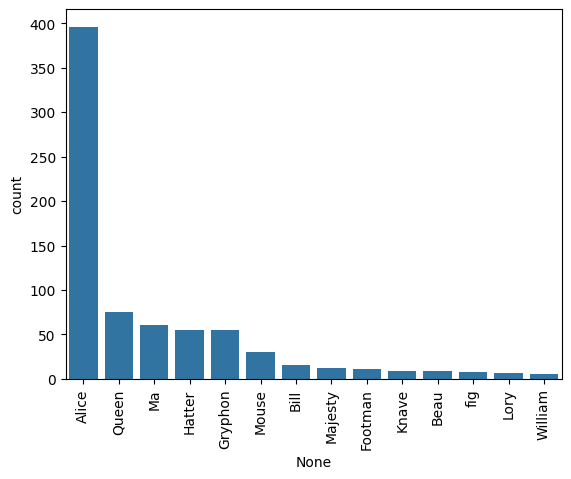

In [99]:
# plot the character occurences

def plot_character_occurences(df: pd.DataFrame) -> None:
    """
    df: pd.DataFrame
    returns a plot of character occurences.
    
    This is function that takes a pandas dataframe of characters and their associated count 
    and returns a plot of character occurences. 
    """
    sns.barplot(x=df.index, y=df["count"])
    plt.xticks(rotation=90)
    plt.show()

plot_character_occurences(df)